# DYOD - Using ANN from Kudzu Lirary
> Distinguishing handwritten digits taken from mnist library using a Multi Layer Perceptron

- branch: master
- badges: true
- comments: true
- author: PrasannaDK
- categories: [fastpages, jupyter]
- date: 2020-08-06

In [1]:
#hide
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#hide
!pip install mnist

## Binary Classification between 3 and 8

The scope and objective of the following code is only to distinguish or classify images as either a 3 or 8

### Getting the Data

In [4]:
import mnist

In [5]:
#collapse_show
train_images = mnist.train_images()
train_labels = mnist.train_labels()
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [6]:
#hide
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

Displaying a random image

6


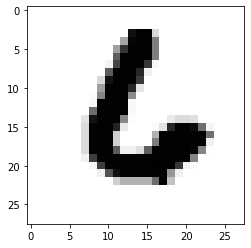

In [7]:
#hide_input
image_index = np.random.randint(0, len(train_labels), 1)[0] # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys');

### Preparing Data: Filter data to get 3 and 8 out

In [8]:
#collapse_show
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

3


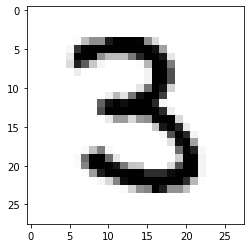

In [9]:
#hide_input
image_index = np.random.randint(0, len(y_train), 1)[0] # You may select anything up to 60,000
print(y_train[image_index]) 
plt.imshow(X_train[image_index], cmap='Greys');

We normalize the pizel values in the 0 to 1 range

In [10]:
#hide
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [11]:
#hide
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [12]:
#hide
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11982, 28, 28), (1984, 28, 28), (11982,), (1984,))

We reshape the data to flatten the image pixels into a set of features or co-variates

In [13]:
#hide
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape, y_train.shape

((11982, 784), (1984, 784), (11982,))

### Multi-Layer Perceptron Model

#### Setup

The following configuration of layers was used to set up the model for training:
1. A first affine layer which has 784 inputs and does 100 affine transforms. These are followed by a `Relu`
2. A second affine layer which has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a `Relu`
3. A third affine layer which has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
4. A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.

<img src="images/MLP.png" title='Multi-Layer Perceptron' style="width:25rem;height:30rem">

In [14]:
from kudzu.data import Data, Dataloader, Sampler
from kudzu.callbacks import AccCallback, ClfCallback
from kudzu.loss import MSE, BCE
from kudzu.layer import Affine, Sigmoid, Relu, Tanh
from kudzu.model import Model
from kudzu.optim import GD
from kudzu.train import Learner
from collections import namedtuple

In [15]:
#hide
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 10
config.bs = 50

In [16]:
#hide
dataSets = namedtuple('dataSets', ['X_train','y_train', 'X_test','y_test'])
dataSet = dataSets(X_train, y_train.reshape(-1,1), X_test, y_test.reshape(-1,1))

In [17]:
#collapse_show
#Setting up classes
data = Data(dataSet.X_train, dataSet.y_train)
loss = BCE()
opt = GD(config.lr)
sampler = Sampler(data, config.bs, shuffle=True)
dl = Dataloader(data, sampler)

In [18]:
#collapse_show
#Setting up model
nn_layers = [Affine("FirstAffine", 784, 100),  Relu("FirstRelu"), Affine("SecondAffine", 100, 100), Relu("SecondRelu"), Affine("Embedding", 100, 2), Affine("LastAffine", 2, 1), Sigmoid("LastSigmoid")]
nn_model = Model(nn_layers)

In [19]:
#collapse_show
#Setting up training
nn_learner = Learner(loss, nn_model, opt, config.num_epochs)
nn_acc = ClfCallback(nn_learner, config.bs, dataSet)
nn_learner.set_callbacks([nn_acc])

#### Traning the Multi Layer Perceptron

In [20]:
nn_learner.train_loop(dl)

Epoch 0 Loss 0.6289509926180616
Epoch 0 Train-Accuracy 0.7896845267901853 Test-Accuracy 0.8220766129032258


0.09064810553951957

#### Analyzing and PLotting results

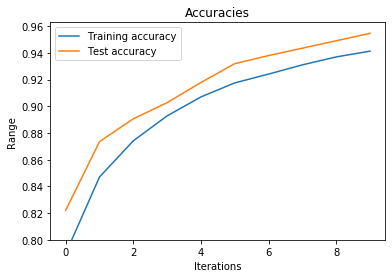

In [21]:
#hide_input
plt.plot(nn_acc.accuracies, label = 'Training accuracy')
plt.plot(nn_acc.test_accuracies, label = 'Test accuracy')
plt.ylim(0.8)
plt.title("Accuracies")
plt.xlabel('Iterations')
plt.ylabel('Range')
plt.legend();

The model is already overfitting; the validation accuracy has dipped below the training accuracy, and they are diverging.
Overfitting happens when the model is quite complex and is fitting to the noise in the training set rather than the signal.

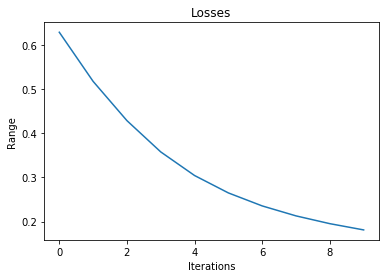

In [22]:
#hide_input
plt.plot(nn_acc.losses)
plt.title("Losses")
plt.xlabel('Iterations')
plt.ylabel('Range');

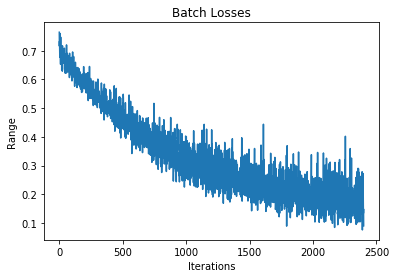

In [23]:
#hide_input
plt.plot(nn_acc.batch_losses)
plt.title("Batch Losses")
plt.xlabel('Iterations')
plt.ylabel('Range');

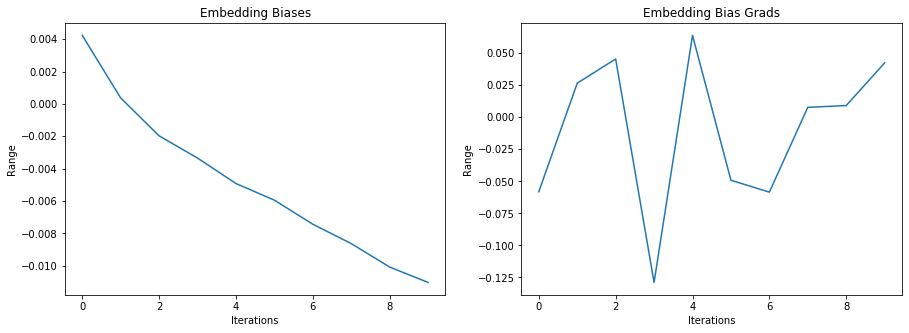

In [24]:
#hide_input
plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.plot(nn_acc.get_biases('Embedding'))
plt.title("Embedding Biases")
plt.xlabel('Iterations')
plt.ylabel('Range')
plt.subplot(122)
plt.plot(nn_acc.get_biasgrads('Embedding'))
plt.title("Embedding Bias Grads")
plt.xlabel('Iterations')
plt.ylabel('Range');

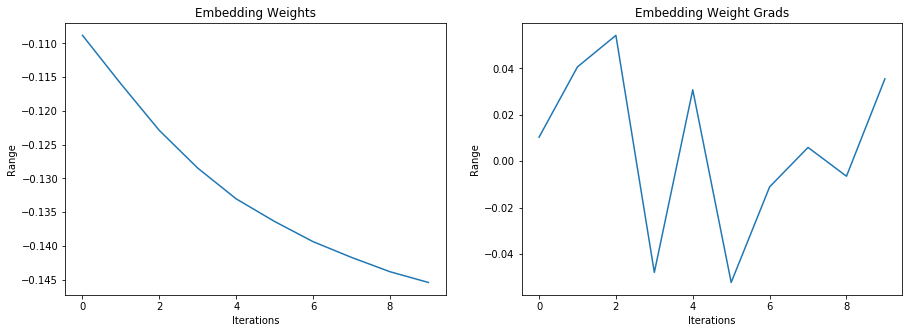

In [25]:
#hide_input
plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.plot(nn_acc.get_weights('Embedding', 0))
plt.title("Embedding Weights")
plt.xlabel('Iterations')
plt.ylabel('Range')
plt.subplot(122)
plt.plot(nn_acc.get_weightgrads('Embedding', 0))
plt.title("Embedding Weight Grads")
plt.xlabel('Iterations')
plt.ylabel('Range');

#### Estimating Accuracies and Making predictions

In [26]:
#collapse
nn_probs_train = nn_model(dataSet.X_train)
print(nn_probs_train[:10])
nn_predictions_train = (nn_probs_train >= 0.5)*1
nn_validateTrain = (nn_predictions_train == dataSet.y_train)
nn_validateTrain_acc = np.mean(nn_validateTrain)
"Trani Accuracy is", nn_validateTrain_acc

[[0.96925196]
 [0.98736357]
 [0.99745155]
 [0.03108037]
 [0.99910811]
 [0.94415612]
 [0.10233384]
 [0.0269406 ]
 [0.83012516]
 [0.05694769]]


('Trani Accuracy is', 0.9413286596561509)

In [27]:
#collapse
nn_validateTest = (nn_model(dataSet.X_test) >= 0.5)*1 == dataSet.y_test
nn_validateTest_acc = np.mean(nn_validateTest)
"Test Accuracy is", nn_validateTest_acc

('Test Accuracy is', 0.9546370967741935)

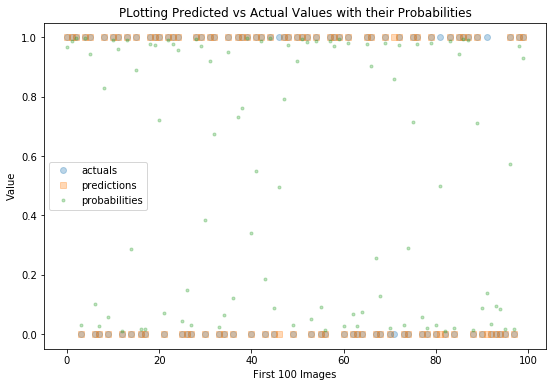

In [28]:
#hide_input
plt.figure(figsize=(9, 6))
plt.plot(dataSet.y_train[:100], 'o',alpha=0.3, label="actuals")
plt.plot(nn_predictions_train[:100], 's',alpha=0.3, label="predictions")
plt.plot(nn_probs_train[:100],'.', alpha=0.3, label="probabilities")
#plt.axvline(-b/w, 0,1,color='r', alpha=0.4, label="dividing line")
plt.title("PLotting Predicted vs Actual Values with their Probabilities")
plt.xlabel('First 100 Images')
plt.ylabel('Value');
plt.legend();

You can visually see some points stranded on the wrong side of the plot

#### Finding False Positives and False Negatives

In [29]:
#collapse
from sklearn.metrics import confusion_matrix
confMat = confusion_matrix(dataSet.y_train, nn_predictions_train)
confMat

array([[5560,  291],
       [ 412, 5719]], dtype=int64)

In [30]:
#hide_input
#FalseNegatives
falseNegatives = confMat[1,0]
"FalseNegatives",falseNegatives

('FalseNegatives', 412)

In [31]:
#hide_input
#FalsePositives
falsePositives = confMat[0,1]
"FalsePositives",falsePositives

('FalsePositives', 291)

#### Embedding Space

In [32]:
#collapse_show
#Embedding space
#layers = [Affine("FirstAffine", 784, 100),  Relu("FirstRelu"), Affine("SecondAffine", 100, 100), Relu("SecondRelu"), Affine("Embedding", 100, 2), Affine("LastAffine", 2, 1), Sigmoid("LastSigmoid")]
FirstAffine = nn_model.layers[0]
FirstRelu = nn_model.layers[1]
SecondAffine = nn_model.layers[2]
SecondRelu = nn_model.layers[3]
Embedding = nn_model.layers[4]
embOutput = Embedding(SecondRelu(SecondAffine(FirstRelu(FirstAffine(dataSet.X_train)))))
embOutput

array([[-2.47971086, -0.45526437],
       [-3.10147265, -0.21008733],
       [-4.20032779,  0.27931729],
       ...,
       [ 1.45849965, -0.879902  ],
       [-2.11339739, -0.11352185],
       [ 1.68587549, -0.38262777]])

In [33]:
#hide
#plt.scatter(np.linspace(np.min(embOutput[:1000,0]),np.max(embOutput[:1000,0]),1000), embOutput[:1000,0])
#plt.scatter(np.linspace(np.min(embOutput[:1000,1]),np.max(embOutput[:1000,1]),1000),embOutput[:1000,1])

In [34]:
#hide
embOutput[:,0]

array([-2.47971086, -3.10147265, -4.20032779, ...,  1.45849965,
       -2.11339739,  1.68587549])

In [35]:
#hide
emb_3 = embOutput[y_train==1]
emb_8 = embOutput[y_train==0]
emb_3.shape, emb_3, emb_8.shape, emb_8

((6131, 2),
 array([[-2.47971086, -0.45526437],
        [-3.10147265, -0.21008733],
        [-4.20032779,  0.27931729],
        ...,
        [-3.04123891,  0.10714512],
        [-2.25228464,  0.26680569],
        [-2.11339739, -0.11352185]]),
 (5851, 2),
 array([[ 2.37366949, -0.7942228 ],
        [ 1.43947303, -1.19798981],
        [ 2.50456833, -0.49218208],
        ...,
        [ 2.73128195, -0.78475958],
        [ 1.45849965, -0.879902  ],
        [ 1.68587549, -0.38262777]]))

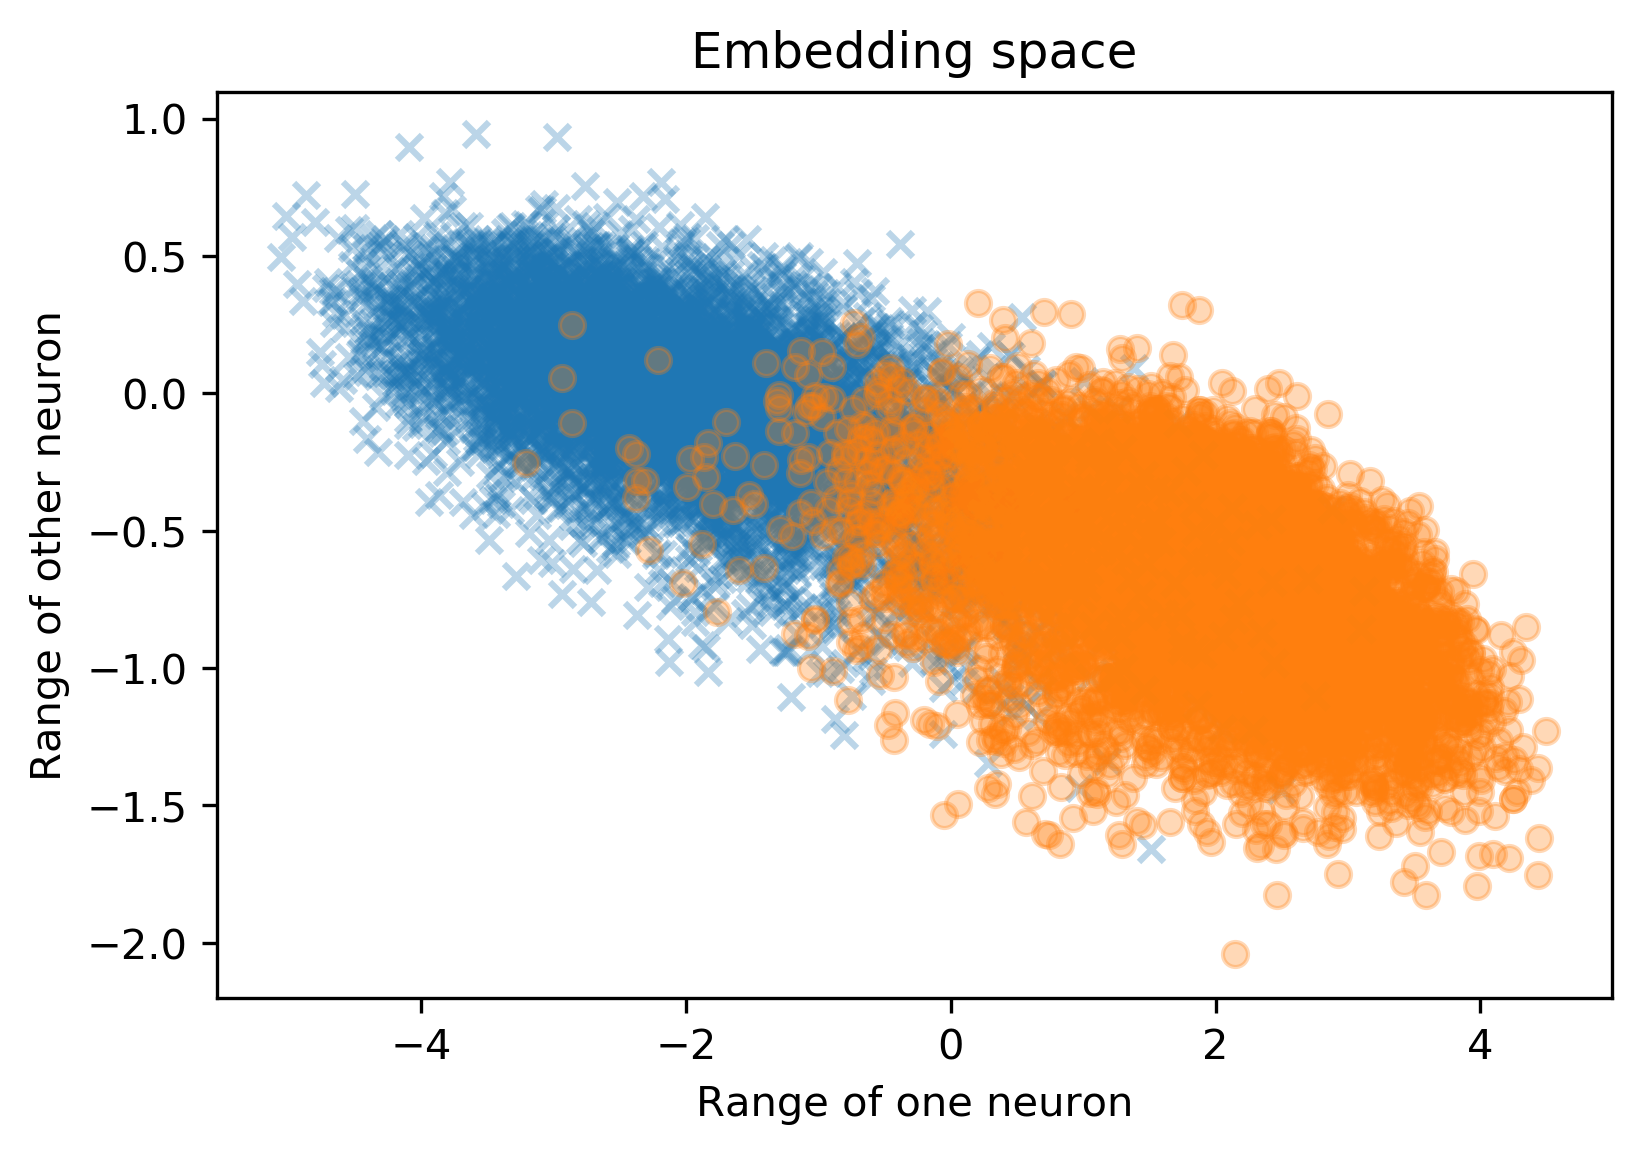

In [36]:
#hide_input
plt.figure(dpi=300)
plt.scatter(emb_3[:,0], emb_3[:,1], alpha = 0.3,marker = 'x')
plt.scatter(emb_8[:,0], emb_8[:,1], alpha = 0.3)
plt.title("Embedding space")
plt.xlabel('Range of one neuron')
plt.ylabel('Range of other neuron');

You can see a clear demarcation / seperation of points in the embedding space. 
We started off with (11982, 784) dimensional image matrix, here each row can now be taken as a vector of 784 dimensions, that is 784 distances along 784 different axes. Now at each layer these "vectors" gets "transformed" into different space and dimensions... So when we come to the embedding layer... these vectors gets "embedded" at different points in space in 2-D depending on where they were (or what they were) when they started out... so the 3's and 8's get seperated in the 2-D plot (ideally)... which can then be visualized.

In [37]:
#hide
b1, w1, w2 = nn_acc.get_biases('LastAffine')[-1], nn_acc.get_weights('LastAffine', 0)[-1], nn_acc.get_weights('LastAffine', 1)[-2]
b1, w1, w2

(0.00828947926825932, -1.4110216933887925, 0.12072061171946981)

In [38]:
#hide
params = nn_model.layers[5].params
w1, w2, b = params['w'][0,0], params['w'][1,0], params['b'][0]
w1, w2, b

(-1.4110216933887925, 0.12414101569942543, 0.00828947926825932)

In [39]:
#hide
affineLine = lambda x1, x2 : w1*x1 + w2*x2 + b
sigmoidProb = lambda x1, x2: 1 / (1 + np.exp(-affineLine(x1,x2)))  

In [40]:
#hide
xgrid = np.linspace(np.min(embOutput[:,0])-1, np.max(embOutput[:,0])+1, 1000)
ygrid = np.linspace(np.min(embOutput[:,1])-1, np.max(embOutput[:,1])+1, 1000)

In [41]:
#hide
X, Y = np.meshgrid(xgrid, ygrid)
X.shape, Y.shape

((1000, 1000), (1000, 1000))

(1000, 1000)


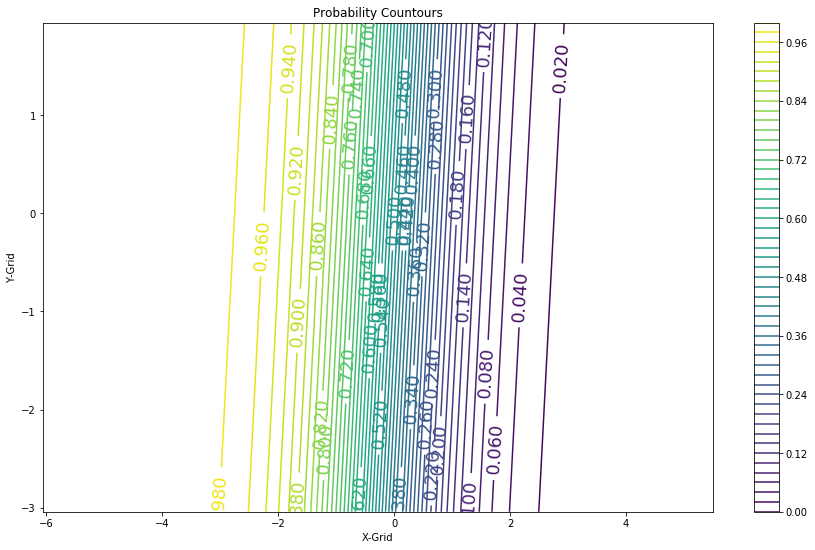

In [42]:
#hide_input
Z = sigmoidProb(X, Y)
print(Z.shape)
plt.figure(figsize=(15, 9))
contours = plt.contour(X, Y, Z,50)
plt.clabel(contours, inline=True, fontsize=18)
plt.colorbar();
plt.title("Probability Countours")
plt.xlabel('X-Grid')
plt.ylabel('Y-Grid');

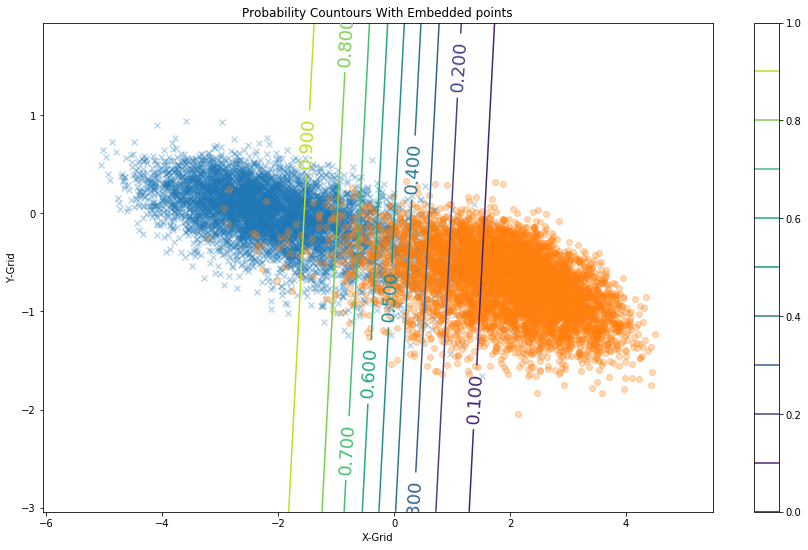

In [43]:
#hide_input
plt.figure(figsize=(15, 9))
contours = plt.contour(X, Y, Z, 10)
plt.clabel(contours, inline=True, fontsize=18)
plt.colorbar();
plt.scatter(emb_3[:,0], emb_3[:,1], alpha = 0.3,marker = 'x')
plt.scatter(emb_8[:,0], emb_8[:,1], alpha = 0.3)
plt.title("Probability Countours With Embedded points")
plt.xlabel('X-Grid')
plt.ylabel('Y-Grid');

In [44]:
#hide
z1 = sigmoidProb(emb_3[:,0], emb_3[:,1])
z2 = sigmoidProb(emb_8[:,0], emb_8[:,1])
z1, z2

(array([0.96925196, 0.98736357, 0.99745155, ..., 0.98678167, 0.96155908,
        0.9514894 ]),
 array([0.03108037, 0.10233384, 0.0269406 , ..., 0.01902059, 0.10350089,
        0.08180907]))

In [45]:
#hide
np.max(z1), np.min(z1), np.max(z2), np.min(z2)

(0.9992605517045302,
 0.011133830052631952,
 0.9889940900773041,
 0.001520419890737358)

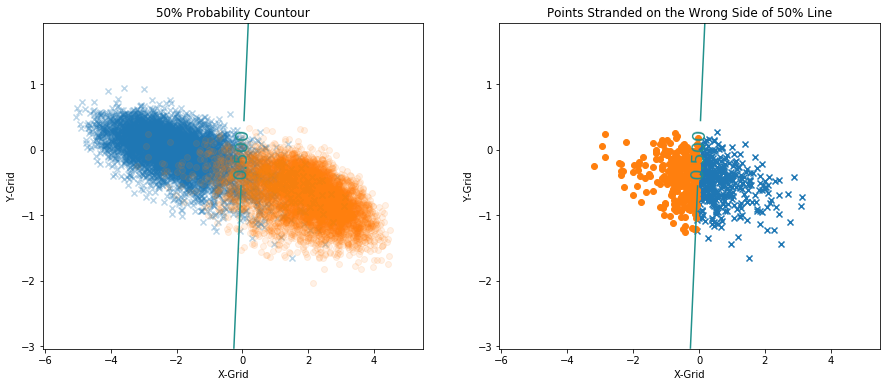

In [46]:
#hide_input
plt.figure(figsize=(15, 6))
plt.subplot(121)
contours = plt.contour(X, Y, Z, 1)
plt.clabel(contours, inline=True, fontsize=18)
plt.scatter(emb_3[:,0], emb_3[:,1], alpha = 0.3,marker = 'x')
plt.scatter(emb_8[:,0], emb_8[:,1], alpha = 0.1)
plt.title("50% Probability Countour")
plt.xlabel('X-Grid')
plt.ylabel('Y-Grid');
plt.subplot(122)
contours = plt.contour(X, Y, Z, 1)
plt.clabel(contours, inline=True, fontsize=18)
plt.scatter(emb_3[z1 < 0.5, 0], emb_3[z1 < 0.5, 1], alpha = 1,marker = 'x')
plt.scatter(emb_8[z2 >= 0.5, 0], emb_8[z2 >= 0.5, 1], alpha = 1)
plt.title("Points Stranded on the Wrong Side of 50% Line")
plt.xlabel('X-Grid')
plt.ylabel('Y-Grid');

Visualizing the probabilities of points in 3-D space (following a sigmoidal shape), along with the predicted and actual values (The misclassified points can also be seen). The embedding space is also drawn for better understanding (The plot is visualized at multiple angles for better clarity).

In [47]:
#hide
from mpl_toolkits.mplot3d import Axes3D

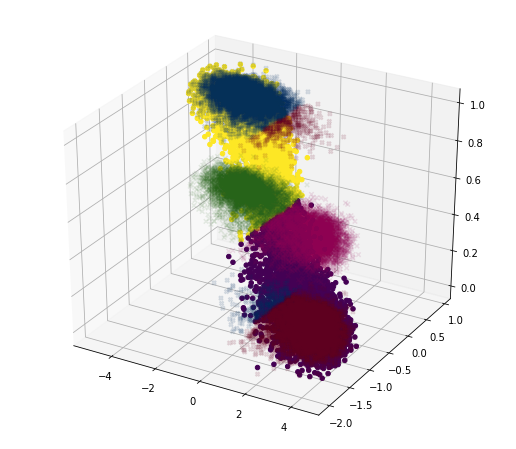

In [48]:
#hide_input
fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(111, projection='3d')
l, m, n = embOutput[:,0], embOutput[:,1], sigmoidProb(embOutput[:,0],embOutput[:,1])
ax.scatter(l, m, n, c = n >= 0.5, marker='o', alpha=1)    #Plotting the probabilities in 3-D space
#ax.scatter(l, m, 1*(n>0.5), c = (1*(n>0.5) == y_train[:]), marker ='s', cmap="RdBu", alpha = 0.1)    #Plotting the predictions with color coding from comparison with the actuals, thus showing the wrongly classified points
ax.scatter(l, m, y_train[:], c = n >= 0.5, marker ='X', cmap="RdBu", alpha = 0.1)    #Plotting the actuals with color coding from predictions, thus showing the wrongly classified points
ax.scatter(l, m, 0.5, c = n >= 0.5, marker='x', cmap="PiYG", alpha = 0.1)    #Plotting the embedding space across the middle
#i , j = np.meshgrid(embOutput[:100,0], embOutput[:100,1])
#ax.plot_surface(i, j, sigmoidProb(i, j))
plt.show()

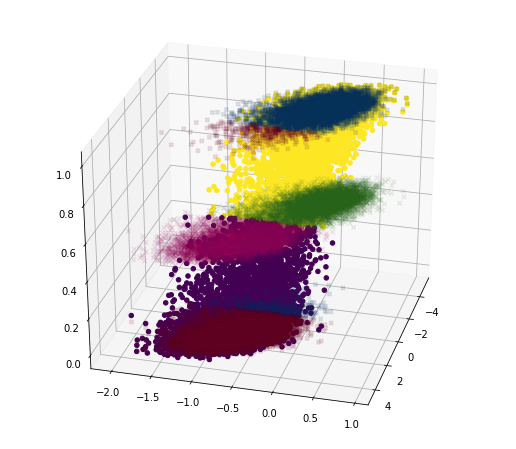

In [49]:
#hide
ax.view_init(elev=30, azim=15)
fig

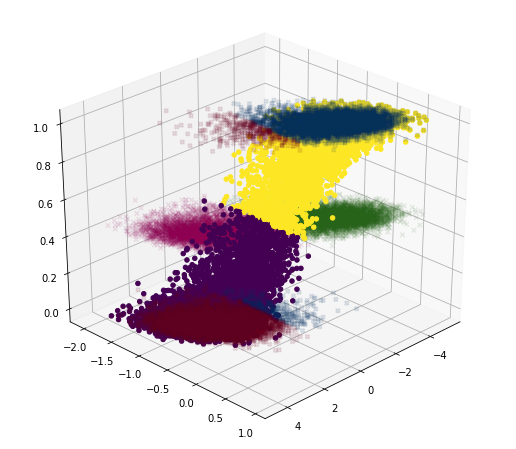

In [50]:
#hide
ax.view_init(elev=30, azim=45)
fig

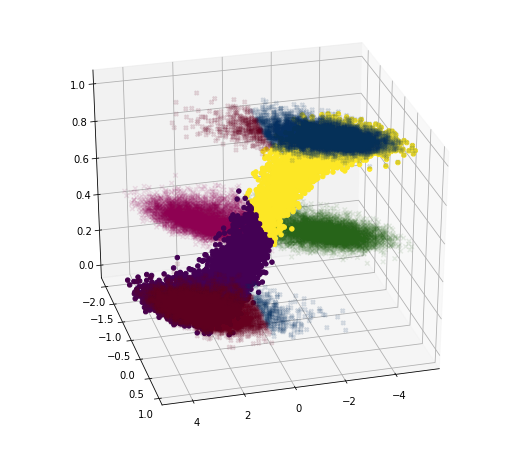

In [51]:
#hide
ax.view_init(elev=30, azim=75)
fig

### Logistic Regression model

In [52]:
#collapse_show
#Setting up model
lr_layers = [Affine("FirstAffine", 784, 1), Sigmoid("LastSigmoid")]
lr_model = Model(lr_layers)

In [53]:
#collapse_show
#Setting up training
lr_learner = Learner(loss, lr_model, opt, config.num_epochs)
lr_acc = ClfCallback(lr_learner, config.bs, dataSet)
lr_learner.set_callbacks([lr_acc])

#### Training the Logistic Regression

In [54]:
lr_learner.train_loop(dl)

Epoch 0 Loss 0.6294339446668089
Epoch 0 Train-Accuracy 0.7919379068602904 Test-Accuracy 0.7963709677419355


0.1611278620141101

In [55]:
#hide_input
lr_predictions_train = (lr_model(dataSet.X_train) >= 0.5)*1
lr_validateTrain = ( lr_predictions_train == dataSet.y_train)
lr_validateTrain_acc = np.mean(lr_validateTrain)
"Train Accuracy", lr_validateTrain_acc

('Train Accuracy', 0.9201301952929394)

In [56]:
#hide_input
lr_validateTest = (lr_model(dataSet.X_test) >= 0.5)*1 == dataSet.y_test
lr_validateTest_acc = np.mean(lr_validateTest)
"Test Accuracy", lr_validateTest_acc

('Test Accuracy', 0.9319556451612904)

Comparing Multi Layer Perceptron with Logistic Regression

In [57]:
#hide
#Train
if nn_validateTrain_acc > lr_validateTrain_acc:
    print("Multi Layer Perceptron is better than Logistic Regression in Train Accuracies by -", nn_validateTrain_acc- lr_validateTrain_acc)
elif nn_validateTrain_acc < lr_validateTrain_acc:
    print("Logistic Regression is better than Multi Layer Perceptron in Train Accuracies by -", lr_validateTrain_acc - nn_validateTrain_acc)
else:
    print("Multi Layer Perceptron and Logistic Regression have same performance in Train Accuracies")

Multi Layer Perceptron is better than Logistic Regression in Train Accuracies by - 0.02119846436321149


In [58]:
#hide
#Test
if nn_validateTest_acc > lr_validateTest_acc:
    print("Multi Layer Perceptron is better than Logistic Regression in Test Accuracies by -", nn_validateTest_acc- lr_validateTest_acc)
elif nn_validateTest_acc < lr_validateTest_acc:
    print("Logistic Regression is better than Multi Layer Perceptron in Test Accuracies by -", lr_validateTest_acc - nn_validateTest_acc)
else:
    print("Multi Layer Perceptron and Logistic Regression have same performance in Test Accuracies")

Multi Layer Perceptron is better than Logistic Regression in Test Accuracies by - 0.022681451612903136


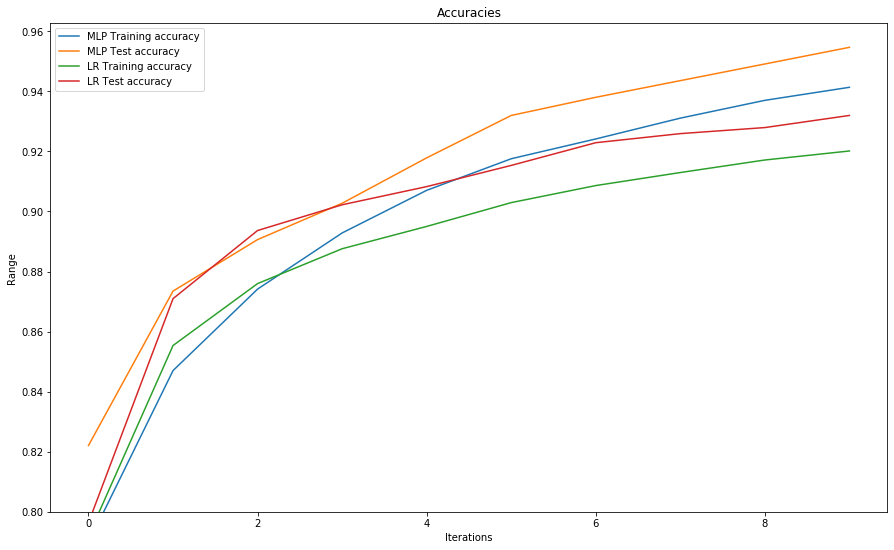

In [59]:
#hide_input
plt.figure(figsize=(15, 9))
plt.plot(nn_acc.accuracies, label = 'MLP Training accuracy')
plt.plot(nn_acc.test_accuracies, label = 'MLP Test accuracy')
plt.plot(lr_acc.accuracies, label = 'LR Training accuracy')
plt.plot(lr_acc.test_accuracies, label = 'LR Test accuracy')
plt.ylim(0.8)
plt.title("Accuracies")
plt.xlabel('Iterations')
plt.ylabel('Range');
plt.legend();

The Multi Layer Perceptron has greater accuracy and hence can be deemed to have a better performance than the Logistic Regression model.

### Result

Taking a random image and classifying it as 3 or 8

In [60]:
#hide
def is_it_a_3_or_8(index):
    res_pred = (nn_model(dataSet.X_test[index]) >= 0.5)*1
    plt.imshow(dataSet.X_test[index].reshape(28,28), cmap='Greys')
    plt.show()
    if res_pred:
        print("    ", "The above Image is a '3' (Three)")
    else:
        print("    ", "The above Image is a '8' (Eight)")
    print("- - - - - - - - - - - - - - - - - - - -")

We can say with 95.46% certainity that:



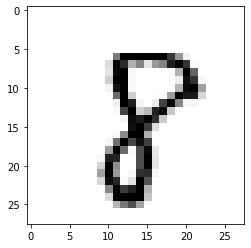

     The above Image is a '8' (Eight)
- - - - - - - - - - - - - - - - - - - -


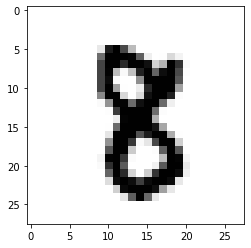

     The above Image is a '8' (Eight)
- - - - - - - - - - - - - - - - - - - -


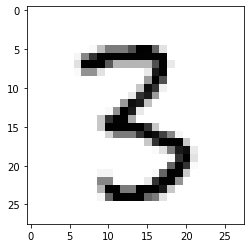

     The above Image is a '3' (Three)
- - - - - - - - - - - - - - - - - - - -


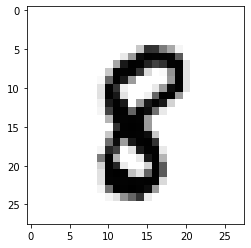

     The above Image is a '8' (Eight)
- - - - - - - - - - - - - - - - - - - -


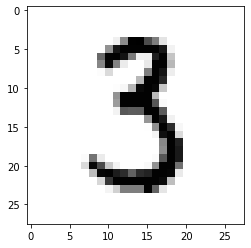

     The above Image is a '3' (Three)
- - - - - - - - - - - - - - - - - - - -


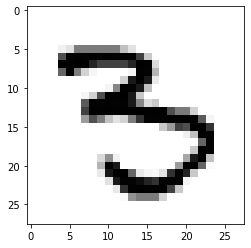

     The above Image is a '3' (Three)
- - - - - - - - - - - - - - - - - - - -


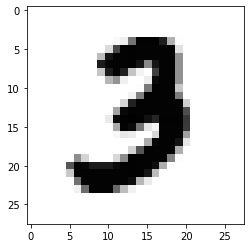

     The above Image is a '3' (Three)
- - - - - - - - - - - - - - - - - - - -


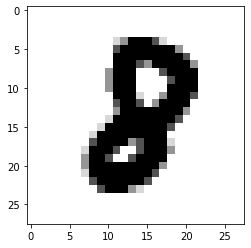

     The above Image is a '8' (Eight)
- - - - - - - - - - - - - - - - - - - -


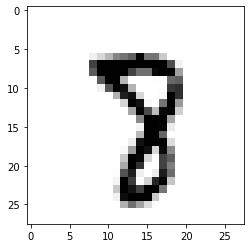

     The above Image is a '8' (Eight)
- - - - - - - - - - - - - - - - - - - -


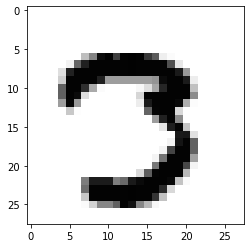

     The above Image is a '3' (Three)
- - - - - - - - - - - - - - - - - - - -


In [61]:
#hide_input
print(f"We can say with {round(nn_validateTest_acc, 4)*100}% certainity that:")
print()
for i in range(10):
    index = np.random.randint(0, len(dataSet.X_test), 1)[0]
    is_it_a_3_or_8(index)

In [62]:
#hide
#### END NOTES

# 1 - A model with specified layers was setup for multi layer perceptron and trained using the given configuration of config object.
# 2 - The call back file was edited to include the ClfCallback which inherited from AccCallback. The class was structured to accomodate the existing epoch_end call in learner class. Data was passed as a named tuple object to the callback object.
# 3 - The model was trained at various epoch values and tested. The change in epoch caussed changes in accuracies, convergence in loss, gradients, weights and bias values. Also the embedding space had different shape and spatial configurations at different epochs.
# 4 - The embedding space is visualized
# 5 - The Multi Layer Perceptron was compared to the Logistic Regression Model
# 6 - A blog was created out of the project

## Categorical classification of all numbers
### Using softmax activation and classification cross entropy

Yet to be implemented

In [63]:
from kudzu.layer import Softmax
from sklearn.preprocessing import OneHotEncoder

In [64]:
#collapse_show
train_images = mnist.train_images()
train_labels = mnist.train_labels()
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [65]:
#hide
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [66]:
#collapse_show
one_hot_encoder = OneHotEncoder(sparse=False)
y_train = one_hot_encoder.fit_transform(train_labels.reshape(-1,1))
print(y_train, y_train[0], train_labels[0])
y_test = one_hot_encoder.fit_transform(test_labels.reshape(-1,1))
X_train = train_images/255.
X_test = test_images/255.

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]] [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 5


In [67]:
#collapse_show
#Setting up model
cc_layers = [Affine("FirstAffine", 784, 64),  Relu("FirstRelu"), Affine("SecondAffine", 64, 64), Relu("SecondRelu"), Affine("LastAffine", 64, 10), Softmax("LastSoftmax")]
cc_model = Model(cc_layers)

In [68]:
#hide
#testing softmax
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
b = cc_model.layers[-1](a)
b, np.sum(b, axis =1)

(array([[0.09003057, 0.24472847, 0.66524096],
        [0.09003057, 0.24472847, 0.66524096],
        [0.09003057, 0.24472847, 0.66524096]]),
 array([1., 1., 1.]))

In [69]:
#hide
#### END NOTES

# 1 - The loss class is edited to include Categorical Cross Entropy and the Layer class is edited to add softmax function
# 2 - However, the complete implementation for complete categorical digit classification is work in progress and might update it at the earliest.